In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import copy
from scipy.stats import shapiro, levene

In [4]:
!pip install pingouin
import pingouin as pg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.6 MB/s eta 0:00:00


**Data Connection**

In [5]:
paths=['/content/drive/MyDrive/Data/Final Project/Sites Energy Consumption Part_001.csv',
       '/content/drive/MyDrive/Data/Final Project/Sites Energy Consumption Part_002.csv',
       '/content/drive/MyDrive/Data/Final Project/Sites Energy Consumption Part_003.csv']

demand = pd.read_excel('/content/drive/MyDrive/Data/Final Project/Demand.xlsx')

dfs=[]
for file in paths:
  df = pd.read_csv(file)
  dfs.append(df)
sites_energy = pd.concat(dfs)
sites_energy

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,"00:00:00 13,01,01",0.219,A,A
1,MAC000002,"00:30:00 13,01,01",0.241,A,A
2,MAC000002,"01:00:00 13,01,01",0.191,A,A
3,MAC000002,"01:30:00 13,01,01",0.235,A,A
4,MAC000002,"02:00:00 13,01,01",0.182,A,A
...,...,...,...,...,...
450962,MAC000100,"18:30:00 13,20,12",0.260,N,B
450963,MAC000100,"19:00:00 13,20,12",0.267,N,B
450964,MAC000100,"19:30:00 13,20,12",0.274,N,B
450965,MAC000100,"20:00:00 13,20,12",0.312,N,B


#Data Exploration and Analysis (EDA)

In [6]:
sites_energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1380252 entries, 0 to 450966
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cell_id                  1380252 non-null  object 
 1   DateTime                 1380252 non-null  object 
 2   KWH/hh (per half hour)   1380252 non-null  float64
 3   site_id                  1380252 non-null  object 
 4   region                   1380252 non-null  object 
dtypes: float64(1), object(4)
memory usage: 63.2+ MB


In [7]:
sites_energy['DateTime'] = pd.to_datetime(sites_energy['DateTime'], errors='coerce', format='%H:%M:%S %y,%d,%m')
sites_energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1380252 entries, 0 to 450966
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   cell_id                  1380252 non-null  object        
 1   DateTime                 1380252 non-null  datetime64[ns]
 2   KWH/hh (per half hour)   1380252 non-null  float64       
 3   site_id                  1380252 non-null  object        
 4   region                   1380252 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 63.2+ MB


In [8]:
sites_energy.describe()

,DateTime,KWH/hh (per half hour)
count,1380252,1.380252e+06
mean,2013-06-29 15:34:13.513706496,2.423353e-01
min,2013-01-01 00:00:00,0.000000e+00
25%,2013-03-30 12:30:00,6.500000e-02
50%,2013-06-28 12:00:00,1.360000e-01
75%,2013-09-27 15:00:00,2.650000e-01
max,2013-12-31 23:30:00,7.657000e+03
std,NaN,6.765435e+00


<Axes: xlabel='region', ylabel='KWH/hh (per half hour) '>

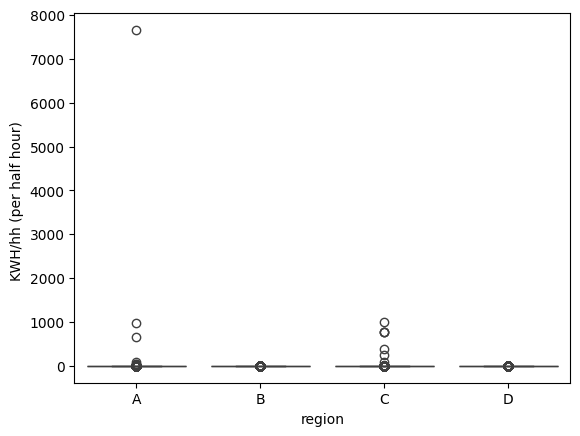

In [9]:
sns.boxplot(data=sites_energy, x='region', y='KWH/hh (per half hour) ')

<ipython-input-10-0f1e9d76bbec>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sites_energy['KWH/hh (per half hour) '])


<Axes: xlabel='KWH/hh (per half hour) ', ylabel='Density'>

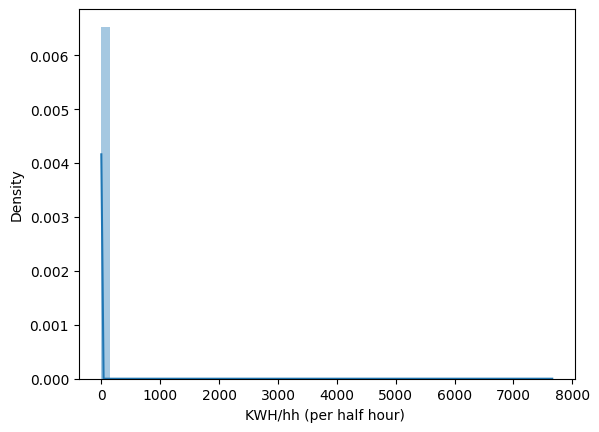

In [10]:
sns.distplot(sites_energy['KWH/hh (per half hour) '])

In [11]:
#check for duplicated values
duplicated = sites_energy[sites_energy.duplicated()]
duplicated

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
961,MAC000002,2013-01-21,0.210,A,A
2450,MAC000002,2013-02-21,0.216,A,A
3939,MAC000002,2013-03-24,0.486,A,A
5428,MAC000002,2013-04-24,0.147,A,A
6917,MAC000002,2013-05-25,0.170,A,A
...,...,...,...,...,...
443865,MAC000100,2013-07-26,0.104,N,B
445354,MAC000100,2013-08-26,0.142,N,B
446843,MAC000100,2013-09-26,0.112,N,B
448332,MAC000100,2013-10-27,0.104,N,B


In [12]:
sites_energy.drop_duplicates(inplace=True)

In [13]:
#check for null values
sites_energy.isna().sum()

,0
cell_id,0
DateTime,0
KWH/hh (per half hour),0
site_id,0
region,0


**Anomaly Detection**

In [14]:
Q1 = sites_energy['KWH/hh (per half hour) '].quantile(0.25)
Q3 = sites_energy['KWH/hh (per half hour) '].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

outliers = sites_energy[(sites_energy['KWH/hh (per half hour) '] > upper_bound) | (sites_energy['KWH/hh (per half hour) '] < lower_bound)]
outliers

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
24,MAC000002,2013-01-01 12:00:00,0.794,A,A
40,MAC000002,2013-01-01 20:00:00,0.886,A,A
41,MAC000002,2013-01-01 20:30:00,0.573,A,A
69,MAC000002,2013-01-02 10:30:00,0.651,A,A
80,MAC000002,2013-01-02 16:00:00,1.078,A,A
...,...,...,...,...,...
450917,MAC000100,2013-12-19 20:00:00,0.852,N,B
450941,MAC000100,2013-12-20 08:00:00,1.652,N,B
450942,MAC000100,2013-12-20 08:30:00,1.053,N,B
450953,MAC000100,2013-12-20 14:00:00,0.678,N,B


* Method Used: The Interquartile Range (IQR) method was applied to identify outliers by calculating the lower and upper bounds using the 25th (Q1) and 75th (Q3) percentiles. Outliers were defined as values beyond 1.5 times the IQR from these bounds.

* Outlier Detection: The rows with values outside the upper and lower bounds were flagged as outliers.

In [15]:
outlier_indices = sites_energy[(sites_energy['KWH/hh (per half hour) '] > upper_bound) | (sites_energy['KWH/hh (per half hour) '] < lower_bound)].index

# Replace outliers with median
sites_energy.loc[outlier_indices, 'KWH/hh (per half hour) '] = sites_energy['KWH/hh (per half hour) '].median()
print(outliers)

          cell_id            DateTime  KWH/hh (per half hour)  site_id region
24      MAC000002 2013-01-01 12:00:00                    0.794       A      A
40      MAC000002 2013-01-01 20:00:00                    0.886       A      A
41      MAC000002 2013-01-01 20:30:00                    0.573       A      A
69      MAC000002 2013-01-02 10:30:00                    0.651       A      A
80      MAC000002 2013-01-02 16:00:00                    1.078       A      A
...           ...                 ...                      ...     ...    ...
450917  MAC000100 2013-12-19 20:00:00                    0.852       N      B
450941  MAC000100 2013-12-20 08:00:00                    1.652       N      B
450942  MAC000100 2013-12-20 08:30:00                    1.053       N      B
450953  MAC000100 2013-12-20 14:00:00                    0.678       N      B
450954  MAC000100 2013-12-20 14:30:00                    0.608       N      B

[120217 rows x 5 columns]


* Replacement Strategy: The detected outliers were replaced with the median value of the dataset to minimize the influence of extreme values.

* Effect of Median Replacement: Replacing outliers with the median helps maintain the central tendency of the data, ensuring it is not skewed by extreme or erroneous values.

In [16]:
demand

,DemandDateTime,Demand
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal
...,...,...
17515,2013-12-31 21:30:00,Normal
17516,2013-12-31 22:00:00,Normal
17517,2013-12-31 22:30:00,Normal
17518,2013-12-31 23:00:00,Normal


In [17]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DemandDateTime  17520 non-null  datetime64[ns]
 1   Demand          17520 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 273.9+ KB


In [18]:
demand.describe()

,DemandDateTime
count,17520
mean,2013-07-02 11:45:00
min,2013-01-01 00:00:00
25%,2013-04-02 05:52:30
50%,2013-07-02 11:45:00
75%,2013-10-01 17:37:30
max,2013-12-31 23:30:00


**Data Consistency**

identifying and correcting inconsistencies in the data, such as variations in spelling, capitalization, or formatting.
italicized text
By replacing these inconsistent values, you're ensuring that the data is uniform and can be processed correctly

In [19]:
demand['Demand'].unique()

array(['Normal', 'Low', 'Normall', 'High', 'normal', 'high'], dtype=object)

In [20]:
value_mapping ={'normal': 'Normal', 'Normall': 'Normal', 'high' : 'High'}
demand['Demand'] = demand['Demand'].replace(value_mapping)

demand['Demand'].unique()

array(['Normal', 'Low', 'High'], dtype=object)

In [21]:
demand = demand.rename(columns={'DemandDateTime': 'DateTime'})

**Merge DataFrames**

Merge operation between two DataFrames, sites_energy and demand, based on the common column 'DateTime'.

In [22]:
df = pd.merge(sites_energy, demand, on = 'DateTime', how = 'left')
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,Normal
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,Normal
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,Normal
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,Normal
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,Normal
...,...,...,...,...,...,...
1379305,MAC000100,2013-12-20 18:30:00,0.136,N,B,Normal
1379306,MAC000100,2013-12-20 19:00:00,0.136,N,B,Normal
1379307,MAC000100,2013-12-20 19:30:00,0.136,N,B,Normal
1379308,MAC000100,2013-12-20 20:00:00,0.136,N,B,Normal


In [23]:
df['region'].unique()
df['site_id'].unique()

array(['A', 'P', 'E', 'Q', 'H', 'L', 'N', 'K', 'J', 'U', 'D', 'F', 'G',
       'C'], dtype=object)

**Demand Prices**

This step aligns energy consumption data with its financial cost, helping to facilitate cost-based analyses or optimization of energy usage.

In [24]:
demand_prices = {
    'High': 77.21,  #price in p/kWh
    'Normal': 19.46,
    'Low': 6.89
}

df['Demand Price'] = df['Demand'].map(demand_prices)

df['Energy Cost'] = df['KWH/hh (per half hour) '] * df['Demand Price']
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Demand Price,Energy Cost
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,Normal,19.46,4.26174
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,Normal,19.46,4.68986
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,Normal,19.46,3.71686
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,Normal,19.46,4.57310
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,Normal,19.46,3.54172
...,...,...,...,...,...,...,...,...
1379305,MAC000100,2013-12-20 18:30:00,0.136,N,B,Normal,19.46,2.64656
1379306,MAC000100,2013-12-20 19:00:00,0.136,N,B,Normal,19.46,2.64656
1379307,MAC000100,2013-12-20 19:30:00,0.136,N,B,Normal,19.46,2.64656
1379308,MAC000100,2013-12-20 20:00:00,0.136,N,B,Normal,19.46,2.64656


**Feature Enginnering**

Extracts meaningful, time-based features from the 'DateTime' column, which can help improve the analysis of patterns over time and enhance predictive models by simplifying and segmenting the time-related data.

In [25]:
df['Date'] = df['DateTime'].dt.date
df['Time'] = df['DateTime'].dt.time
df['Hour'] = df['DateTime'].dt.hour
df = df.drop(columns=['DateTime'])
df

,cell_id,KWH/hh (per half hour),site_id,region,Demand,Demand Price,Energy Cost,Date,Time,Hour
0,MAC000002,0.219,A,A,Normal,19.46,4.26174,2013-01-01,00:00:00,0
1,MAC000002,0.241,A,A,Normal,19.46,4.68986,2013-01-01,00:30:00,0
2,MAC000002,0.191,A,A,Normal,19.46,3.71686,2013-01-01,01:00:00,1
3,MAC000002,0.235,A,A,Normal,19.46,4.57310,2013-01-01,01:30:00,1
4,MAC000002,0.182,A,A,Normal,19.46,3.54172,2013-01-01,02:00:00,2
...,...,...,...,...,...,...,...,...,...,...
1379305,MAC000100,0.136,N,B,Normal,19.46,2.64656,2013-12-20,18:30:00,18
1379306,MAC000100,0.136,N,B,Normal,19.46,2.64656,2013-12-20,19:00:00,19
1379307,MAC000100,0.136,N,B,Normal,19.46,2.64656,2013-12-20,19:30:00,19
1379308,MAC000100,0.136,N,B,Normal,19.46,2.64656,2013-12-20,20:00:00,20


#Data Insights

In [26]:
sites_region = pd.pivot_table(
    data = df,
    index='region',
    values='site_id',
    aggfunc=pd.Series.nunique
)

print(sites_region)

        site_id
region         
A             4
B             5
C             4
D             1


This pivot table helps in understanding the distribution of unique sites across different regions,

It can be used to identify which regions have more or fewer sites, helping to make data-driven decisions.


<Axes: xlabel='Demand', ylabel='KWH/hh (per half hour) '>

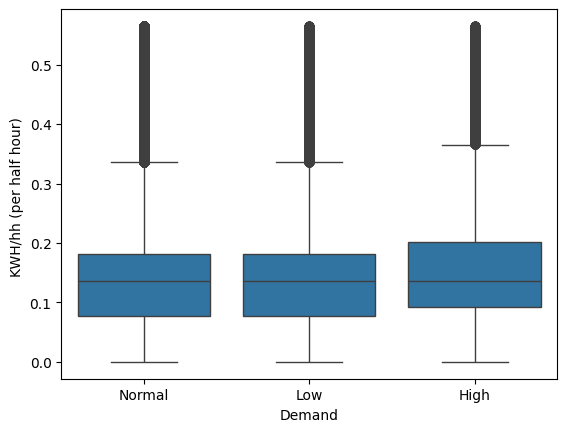

In [27]:
sns.boxplot(data=df, x='Demand', y='KWH/hh (per half hour) ')

The boxplot shows the variation in energy consumption across different demand levels (High, Low, Normal). It highlights:

- Median: The central line inside the box represents the median energy consumption.
- Interquartile Range (IQR): The box shows where most data points lie, with the whiskers indicating the range of values.
- Outliers: Points outside the whiskers are outliers, which could indicate unusual consumption behavior.

<Axes: xlabel='region', ylabel='KWH/hh (per half hour) '>

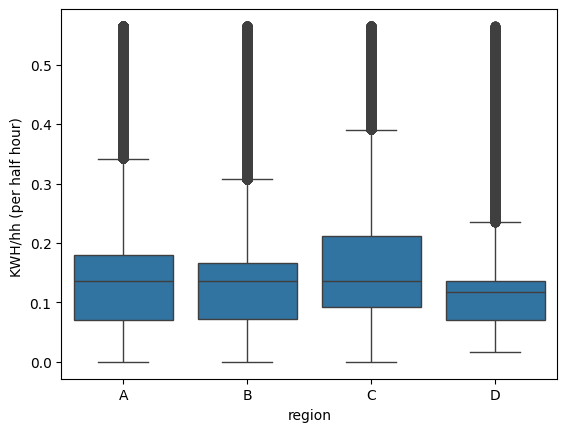

In [28]:
sns.boxplot(data=df, x='region', y='KWH/hh (per half hour) ')

The boxplot shows the variation in energy consumption across different regions, helping to identify:

- Median consumption: The central line inside the box represents the median consumption per region.
- Interquartile Range (IQR): The box shows where the middle 50% of energy consumption values fall for each region.
- Outliers: Any points outside the whiskers represent extreme values or outliers in energy consumption.

<ipython-input-29-aad11c9ac31b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['KWH/hh (per half hour) '])


<Axes: xlabel='KWH/hh (per half hour) ', ylabel='Density'>

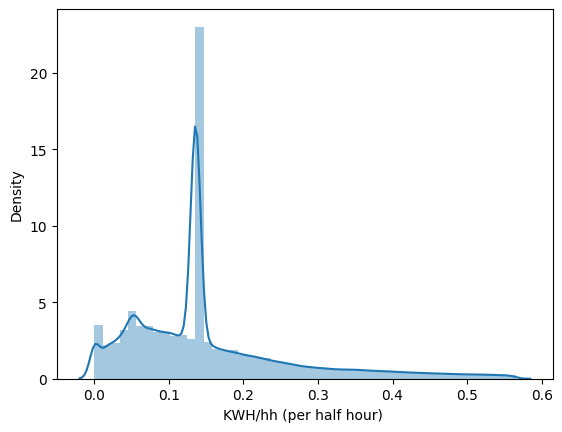

In [29]:
sns.distplot(df['KWH/hh (per half hour) '])

- The histogram shows the frequency of energy consumption values, helping us understand the distribution of energy usage.
- The KDE curve provides a smooth estimate of the probability density function, highlighting regions with higher energy consumption frequencies.
- If the distribution is skewed, this suggests that most energy consumption is concentrated in certain ranges, which can inform decisions on energy-saving strategies.

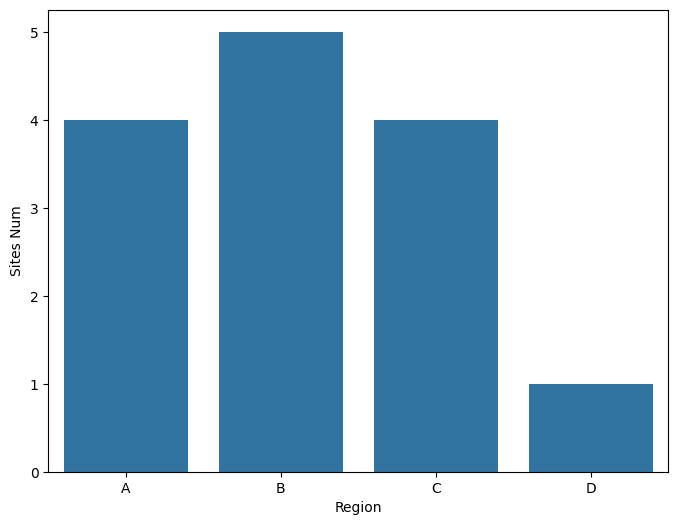

In [31]:
plt.figure(figsize=(8, 6))
sns.barplot(x=sites_region.index, y=sites_region['site_id'])
plt.xlabel("Region")
plt.ylabel("Sites Num")
plt.show()

* Regions A, B, and C are better served in terms of site distribution, with Region B slightly standing out with the highest number of sites.
* Region D has very few sites, which could suggest a need for more resources or expansion in this area.

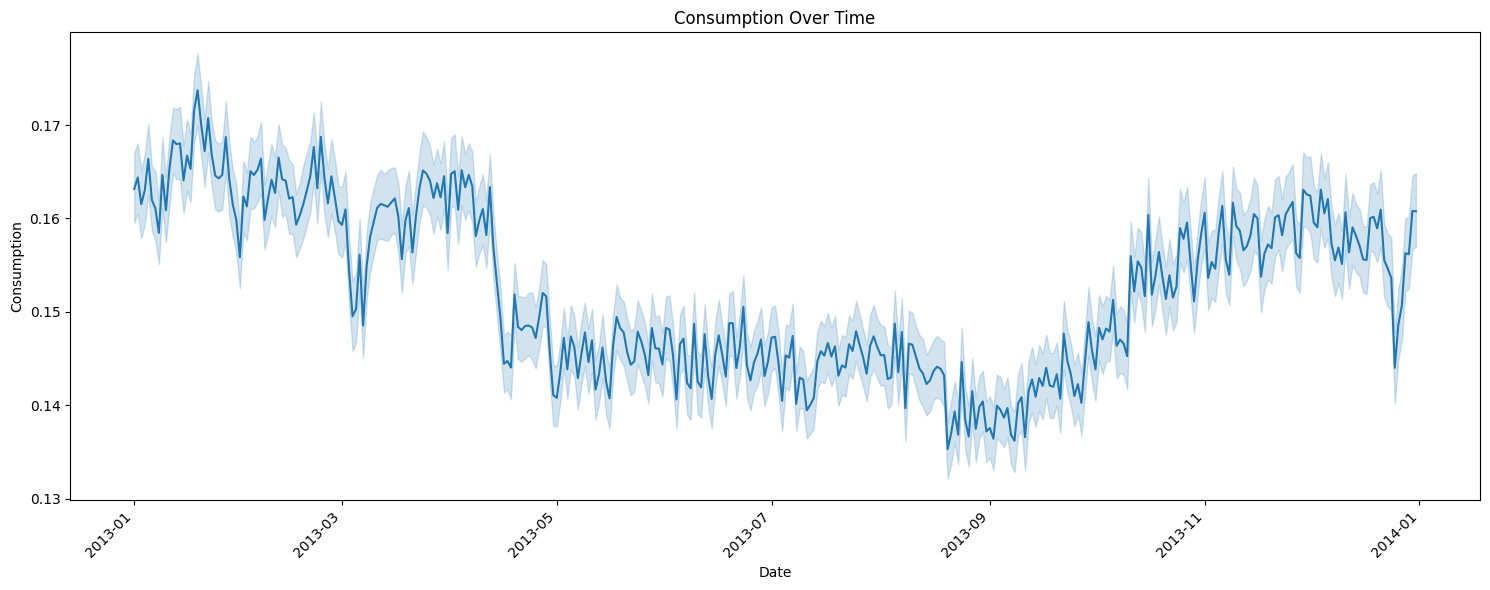

In [32]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date', y='KWH/hh (per half hour) ', data=df)
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Over Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* Fluctuations in consumption are evident, with certain periods showing more significant variation.
* There is a seasonal increase towards the end of 2013, suggesting external factors like temperature changes could be influencing consumption patterns.
* The sharp rise in early 2014 could merit further investigation to understand if it is due to changes in demand, policy, or external influences.

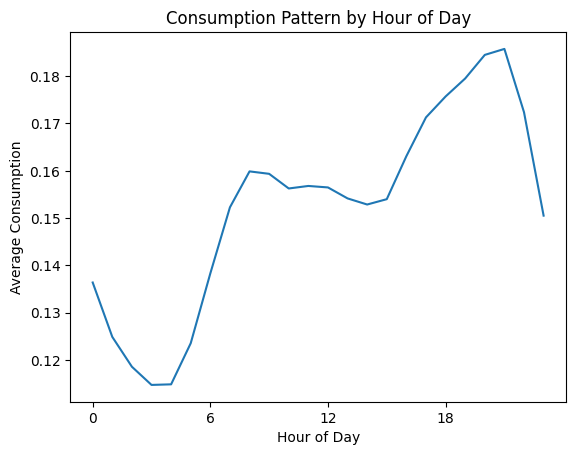

In [33]:
hourly_consumption = df.groupby('Hour')['KWH/hh (per half hour) '].mean().reset_index()

ax = sns.lineplot(x='Hour', y='KWH/hh (per half hour) ', data=hourly_consumption)
plt.xticks(range(0, 24, 6))
plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption')
plt.title('Consumption Pattern by Hour of Day')
plt.show()

* The highest consumption occurs during the evening hours (18:00–24:00), likely related to increased household activities.
* The lowest consumption is observed during the early morning hours (00:00–06:00), which is typical for most residential areas due to fewer activities taking place.
* Steady consumption in the late morning and early afternoon could suggest stable, continuous demand, potentially related to work hours or base usage.

In [34]:
#df.to_csv('Energy_Consumption.csv', index=False)

In [35]:
#df.to_csv('/content/drive/MyDrive/Energy_Consumption.csv', index=False)

#Statistical Hypothesis Testing

**1. Does the region significantly affect energy consumption?**

* ANOVA (Analysis of Variance):

  * Null Hypothesis (H₀): There is no significant difference between the energy consumption of regions.
  * Alternative Hypothesis (H₁): There is a significant difference between the energy consumption of regions.

In [36]:
anova_results = pg.anova(data=df, dv='KWH/hh (per half hour) ', between='region', detailed=True)

print(anova_results)

   Source            SS       DF         MS            F  p-unc       np2
0  region    138.740174        3  46.246725  3715.534485    0.0  0.008017
1  Within  17168.023834  1379306   0.012447          NaN    NaN       NaN


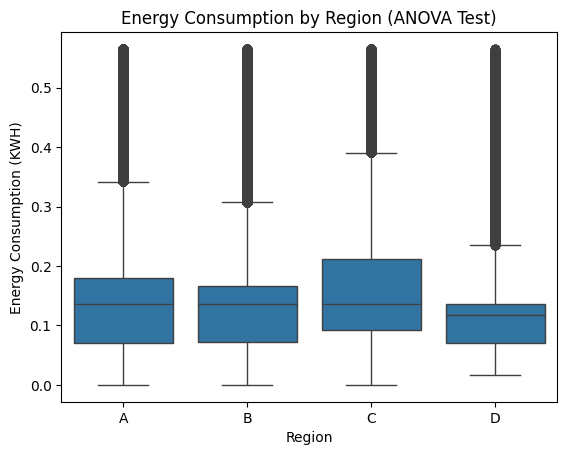

In [37]:
sns.boxplot(x='region', y='KWH/hh (per half hour) ', data=df)
plt.title('Energy Consumption by Region (ANOVA Test)')
plt.xlabel('Region')
plt.ylabel('Energy Consumption (KWH)')
plt.show()

* F-value: 3715.53 (This suggests a large difference between group means relative to within-group variability.)
* p-value: 0.0 (Since the p-value is below 0.05, we reject the null hypothesis.)
* Effect Size (η²): 0.008 (A small effect size, indicating that while significant, the difference in energy consumption is not large.)

In [38]:
pg.pairwise_tests(data = df, dv='KWH/hh (per half hour) ', between='region', padjust = 'sidak')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,region,A,B,False,True,41.327285,973962.605216,two-sided,0.000000e+00,0.0,sidak,inf,0.082791
1,region,A,C,False,True,-65.623147,803356.679870,two-sided,0.000000e+00,0.0,sidak,inf,-0.139472
2,region,A,D,False,True,25.378128,40970.433858,two-sided,5.426255e-141,0.0,sidak,3.572e+137,0.126378
3,region,B,C,False,True,-104.335124,745266.482697,two-sided,0.000000e+00,0.0,sidak,inf,-0.235918
4,region,B,D,False,True,9.586506,40604.864323,two-sided,9.608273e-22,0.0,sidak,5.606e+17,0.054160
5,region,C,D,False,True,52.395656,43252.483870,two-sided,0.000000e+00,0.0,sidak,inf,0.275364


* Energy consumption differs significantly across regions (A, B, C, and D). The pairwise comparisons show that the differences are statistically significant, and the Bayes Factor supports the strength of this evidence.
* The effect sizes are small to moderate, suggesting the differences in energy consumption are noticeable but not extremely large in scale.



* There is a weak positive correlation between Hour (the time of day) and KWH/hh (per half hour) (energy consumption).
* As the hour of the day increases, energy consumption tends to increase slightly.
* The correlation is statistically significant (p-value = 0.0), so this relationship is unlikely to be due to random chance.
* The confidence interval is narrow and entirely positive, reinforcing that the correlation is likely to be positive in the population.
* The power of the test is very high, meaning the result is reliable.

**Checking the assumptions of the statistical tests**

For ANOVA, the main assumptions are:

* Normality: The data within each group (e.g., regions) should be normally distributed.
* Homogeneity of variances: The variance within each group should be approximately equal.

Shapiro-Wilk Test (Normality Test):
 * Null Hypothesis (H₀): The data follows a normal distribution.
 * Alternative Hypothesis (H₁): The data does not follow a normal distribution.

In [39]:
# Calculate group means without modifying the DataFrame
group_means = df.groupby('region')['KWH/hh (per half hour) '].transform('mean')
residuals = df['KWH/hh (per half hour) '] - group_means

# Perform Shapiro-Wilk test on a subset of residuals (for large data)
shapiro_test = shapiro(residuals.sample(5000, random_state=42))  # Adjust sample size as needed
print(f"Shapiro-Wilk test: W = {shapiro_test.statistic}, p-value = {shapiro_test.pvalue}")


Shapiro-Wilk test: W = 0.8761162721735147, p-value = 6.985640719017114e-53


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1379310.
  res = hypotest_fun_out(*samples, **kwds)


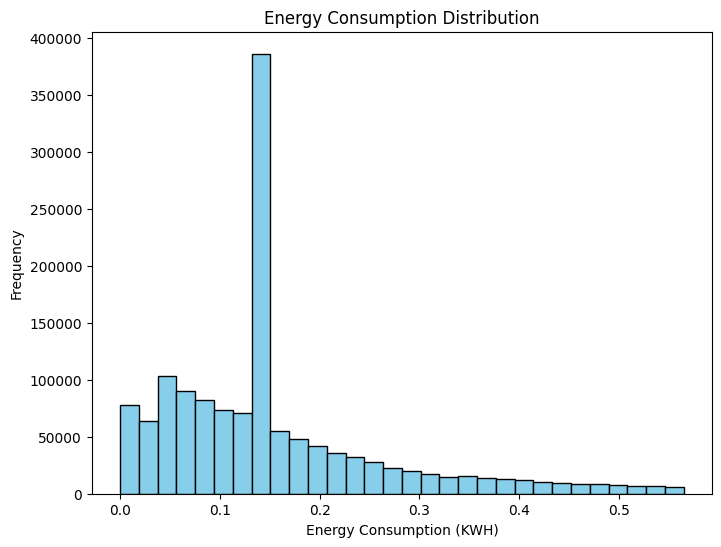

In [40]:
# Perform Shapiro-Wilk test
from scipy import stats
stat, p_value = stats.shapiro(df['KWH/hh (per half hour) '])

plt.figure(figsize=(8,6))
plt.hist(df['KWH/hh (per half hour) '], bins=30, edgecolor='black', color='skyblue')
plt.title('Energy Consumption Distribution')
plt.xlabel('Energy Consumption (KWH)')
plt.ylabel('Frequency')
plt.show()

Normality assumption:


* Shapiro-Wilk test result:

   * W = 0.8761
   * p-value = 6.9856e-53 (very small)

* Interpretation:

   * The p-value is very small (far below 0.05), indicating that the data is not normally distributed.
   * Violation of normality: For ANOVA, the assumption of normality is violated. This suggests that your data does not follow a normal distribution, which could affect the validity of the ANOVA results.

Levene’s Test (Homogeneity of Variances):

* Null Hypothesis (H₀): The variances across groups (regions) are equal.
* Alternative Hypothesis (H₁): The variances across groups (regions) are unequal.

In [41]:
# 2. Homogeneity of variances
group_data = [df.loc[df['region'] == group, 'KWH/hh (per half hour) '] for group in df['region'].unique()]
levene_test = levene(*group_data)
print(f"Levene’s test: W = {levene_test.statistic}, p-value = {levene_test.pvalue}")


Levene’s test: W = 1184.4686918088842, p-value = 0.0


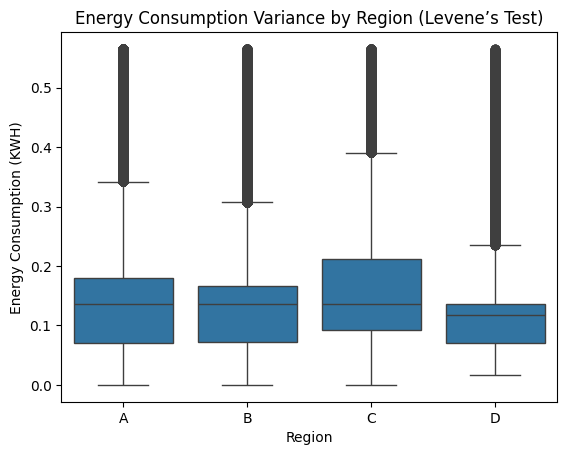

In [42]:
# Assuming 'Region' and 'Energy Consumption' are present
sns.boxplot(x='region', y='KWH/hh (per half hour) ', data=df)
plt.title('Energy Consumption Variance by Region (Levene’s Test)')
plt.xlabel('Region')
plt.ylabel('Energy Consumption (KWH)')
plt.show()

Homogeneity of variance assumption:


* Levene’s test result:

   * W = 1184.4687
   * p-value = 0.0 (extremely small)

* Interpretation:
   * The very small p-value indicates that the assumption of homogeneity of variances (i.e., equal variances across groups) is violated.
   * Violation of homogeneity of variance: This suggests that the variances between the groups (regions in this case) are significantly different, which violates an assumption of ANOVA.

**Discussing any limitations of the analysis or the chosen tests**

Limitations of ANOVA:

* Non-Normality:

 Since the assumption of normality is violated, the results of ANOVA may not be entirely reliable. If the data is skewed, transformations (e.g., log transformation) or non-parametric tests like Kruskal-Wallis could be considered as alternatives.
* Heteroscedasticity:

 The assumption of equal variances is violated (Levene’s test p-value = 0), meaning that ANOVA results may not be robust here. You may consider applying a Welch’s ANOVA, which is an adaptation of ANOVA that does not assume equal variances.
* Outliers:

 If there are outliers in any group, this could significantly affect the results of ANOVA.

**2. Is there a relationship between the time of day and energy consumption?**

In [43]:
correlation_spearman = pg.corr(x=df['Hour'], y=df['KWH/hh (per half hour) '], method='spearman')

print(correlation_spearman)

                n         r         CI95%  p-val  power
spearman  1379310  0.175867  [0.17, 0.18]    0.0    1.0


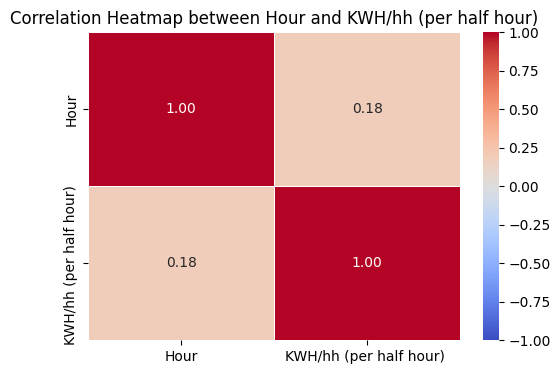

In [44]:
corr_matrix = df[['Hour', 'KWH/hh (per half hour) ']].corr(method='spearman')

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap between Hour and KWH/hh (per half hour)')
plt.show()

**Checking the assumptions of the statistical tests**

Spearman Correlation Test:

* Null Hypothesis (H₀): There is no monotonic relationship between the two variables (e.g., hour of day and energy consumption).
* Alternative Hypothesis (H₁): There is a monotonic relationship between the two variables.

Assumptions for Spearman’s Rank Correlation:

Spearman's correlation is a non-parametric test that has fewer assumptions compared to parametric tests (like Pearson’s correlation), but it still has a few key assumptions:


* Monotonic Relationship:

    * Assumption: Spearman’s test assumes a monotonic relationship between the two variables being correlated.
    * Definition: A monotonic relationship means that as one variable increases, the other variable either always increases or always decreases, but not necessarily at a constant rate.
* Monotonicity Check:
   
    * From the Spearman correlation output, the correlation coefficient r=0.175867 suggests a positive relationship.
    * However, the weak correlation indicates that the monotonic relationship is relatively weak. Despite this, since Spearman is designed for non-linear relationships, the exact form of the relationship is not critical as long as it's monotonic.
Data Type:

* Assumption: Spearman’s correlation requires at least ordinal data, meaning data that has a meaningful order. However, it can also be used with interval and ratio data.
Method: Spearman ranks the data and compares these ranks rather than comparing the raw data directly.

**Discussing any limitations of the analysis or the chosen tests**

Limitations of Spearman’s Rank Correlation:


* Weak Correlation:

 A value of r = 0.175867 suggests a weak positive correlation between 'Hour' and 'KWH/hh (per half hour)'. This means that, while there is some positive relationship, it's not very strong. This result indicates that other factors may be influencing the data, and relying solely on the Spearman correlation might not give a complete picture.
* Monotonicity Assumption:

 If the relationship between the variables is not monotonic (e.g., a U-shaped curve), then Spearman's correlation would not be appropriate.
* Outliers:

 Spearman correlation can be sensitive to outliers, even though it’s more robust than Pearson's correlation. If outliers exist in your data, they could distort the correlation results.

#Threshold Recommendation and Cost Savings

* Threshold Determination

  * Calculate Threshold Using Percentile

   determined a threshold using the 10th percentile of the energy consumption column, KWH/hh (per half hour). This means you identified the value below which the lowest 25% of the energy consumption values lie.

  * Why the 25th Percentile?
  
   The 25th percentile represents low energy usage. Cells below this value are consuming relatively minimal energy and are candidates for potential shutdown to save energy and costs.

In [45]:
percentile_25 = df['KWH/hh (per half hour) '].quantile(0.25)

threshold = percentile_25

#Identify Low-Consumption Cells
low_consumption_cells = df[df['KWH/hh (per half hour) '] < threshold]
low_consumption_cells

,cell_id,KWH/hh (per half hour),site_id,region,Demand,Demand Price,Energy Cost,Date,Time,Hour
13,MAC000002,0.076,A,A,Normal,19.46,1.47896,2013-01-01,06:30:00,6
20,MAC000002,0.076,A,A,Normal,19.46,1.47896,2013-01-01,10:00:00,10
62,MAC000002,0.073,A,A,Normal,19.46,1.42058,2013-01-02,07:00:00,7
111,MAC000002,0.075,A,A,Normal,19.46,1.45950,2013-01-03,07:30:00,7
161,MAC000002,0.072,A,A,Normal,19.46,1.40112,2013-01-04,08:30:00,8
...,...,...,...,...,...,...,...,...,...,...
1379272,MAC000100,0.076,N,B,Low,6.89,0.52364,2013-12-20,02:00:00,2
1379275,MAC000100,0.064,N,B,Low,6.89,0.44096,2013-12-20,03:30:00,3
1379276,MAC000100,0.065,N,B,Low,6.89,0.44785,2013-12-20,04:00:00,4
1379277,MAC000100,0.066,N,B,Low,6.89,0.45474,2013-12-20,04:30:00,4


* Cost Savings Calculation

 * Evaluation of Energy and Cost Savings:

   The energy and cost values of the low-consumption cells (those below the threshold) were summed to estimate the potential savings if these cells were shut down.  

 * Comparison with Total Energy and Cost:

   The total energy consumption and cost for the entire dataset were calculated to provide a clear understanding of the overall impact before and after applying the threshold. This comparison highlights the potential reduction in energy usage and associated costs.

In [46]:
# Total energy and cost in the entire dataset
total_energy_before = df['KWH/hh (per half hour) '].sum()
total_cost_before = df['Energy Cost'].sum()

print(f"Total Energy Before Threshold: {total_energy_before:.2f} KWH")
print(f"Total Cost Before Threshold: {total_cost_before:.2f} EGP")


Total Energy Before Threshold: 210131.59 KWH
Total Cost Before Threshold: 4429805.61 EGP


In [47]:
# Total energy and cost for cells above the threshold
remaining_cells = df[df['KWH/hh (per half hour) '] >= threshold]
remaining_energy = remaining_cells['KWH/hh (per half hour) '].sum()
remaining_cost = remaining_cells['Energy Cost'].sum()

print(f"Total Energy After Threshold: {remaining_energy:.2f} KWH")
print(f"Total Cost After Threshold: {remaining_cost:.2f} EGP")


Total Energy After Threshold: 196263.22 KWH
Total Cost After Threshold: 4146589.61 EGP


* Calculation of Savings for Low-Consumption Cells:

   * Results:
   The threshold (25th percentile), along with the total energy and monetary savings, was output to provide a clear understanding of the impact of shutting down these low-consumption cells.  

   * Energy Savings:  
   The total energy consumption for cells below the 10th percentile threshold was calculated, representing the potential energy savings in kilowatt-hours (KWH).  

   * EGP Savings:  
   The total monetary savings were determined by summing up the energy costs of these low-consumption cells.

In [48]:
# Calculate the total energy consumption for low-consumption cells
total_kw_savings = low_consumption_cells['KWH/hh (per half hour) '].sum()

# Calculate the total monetary savings for low-consumption cells
total_egp_savings = low_consumption_cells['Energy Cost'].sum()

# Output the results
print(f"Threshold (25th Percentile): {threshold}")
print(f"Total KW Savings: {total_kw_savings:.2f} KWH")
print(f"Total EGP Savings: {total_egp_savings:.2f} EGP")


Threshold (25th Percentile): 0.078
Total KW Savings: 13868.37 KWH
Total EGP Savings: 283216.00 EGP


* Breakdown of Savings by Demand:

 The total energy (KW) and cost (EGP) savings were calculated separately for each demand level, showing the potential savings for cells within each demand category.

In [49]:
low_consumption_cells = df[df['KWH/hh (per half hour) '] < threshold]

low_consumption_by_demand = low_consumption_cells.groupby('Demand').agg(
    total_kw_savings=('KWH/hh (per half hour) ', 'sum'),
    total_egp_savings=('Energy Cost', 'sum')
)

for demand_level, row in low_consumption_by_demand.iterrows():
    print(f"Demand Level: {demand_level}")
    print(f"  Total KW Savings: {row['total_kw_savings']:.2f} KWH")
    print(f"  Total EGP Savings: {row['total_egp_savings']:.2f} EGP")
    print("-" * 50)

Demand Level: High
  Total KW Savings: 521.51 KWH
  Total EGP Savings: 40265.94 EGP
--------------------------------------------------
Demand Level: Low
  Total KW Savings: 1334.90 KWH
  Total EGP Savings: 9197.49 EGP
--------------------------------------------------
Demand Level: Normal
  Total KW Savings: 12011.95 KWH
  Total EGP Savings: 233752.57 EGP
--------------------------------------------------


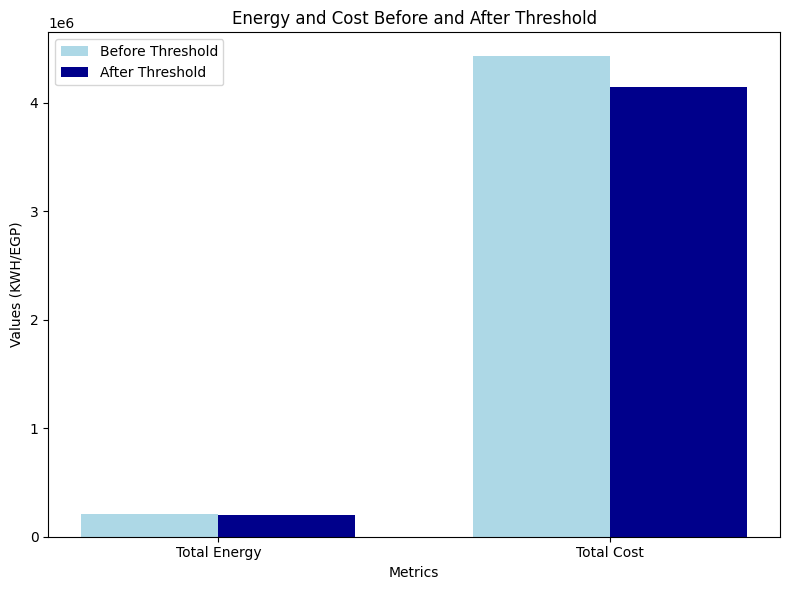

In [50]:
labels = ['Total Energy', 'Total Cost']
before_values = [total_energy_before, total_cost_before]
after_values = [remaining_energy, remaining_cost]

x = range(len(labels))

fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35

ax.bar(x, before_values, bar_width, label='Before Threshold', color='lightblue')
ax.bar([p + bar_width for p in x], after_values, bar_width, label='After Threshold', color='darkblue')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values (KWH/EGP)')
ax.set_title('Energy and Cost Before and After Threshold')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Show the chart
plt.tight_layout()
plt.show()

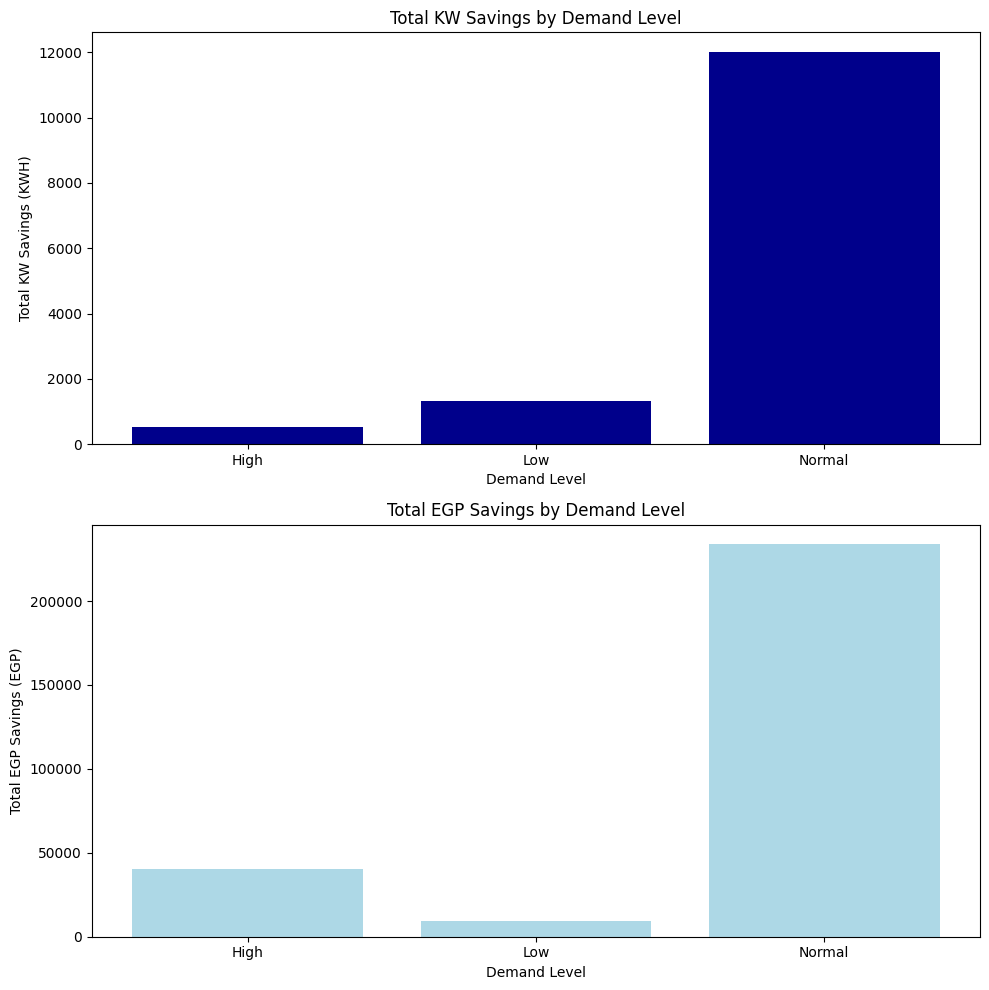

In [54]:
# Calculate the 25th percentile threshold
threshold = df['KWH/hh (per half hour) '].quantile(0.25)

# Identify low-consumption cells
low_consumption_cells = df[df['KWH/hh (per half hour) '] < threshold]

# Calculate savings by demand level
low_consumption_by_demand = low_consumption_cells.groupby('Demand').agg(
    total_kw_savings=('KWH/hh (per half hour) ', 'sum'),
    total_egp_savings=('Energy Cost', 'sum')
)

# Plot the savings by demand level
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot KW savings
ax[0].bar(low_consumption_by_demand.index, low_consumption_by_demand['total_kw_savings'], color='darkblue')
ax[0].set_title('Total KW Savings by Demand Level')
ax[0].set_xlabel('Demand Level')
ax[0].set_ylabel('Total KW Savings (KWH)')

# Plot EGP savings
ax[1].bar(low_consumption_by_demand.index, low_consumption_by_demand['total_egp_savings'], color='lightblue')
ax[1].set_title('Total EGP Savings by Demand Level')
ax[1].set_xlabel('Demand Level')
ax[1].set_ylabel('Total EGP Savings (EGP)')

plt.tight_layout()
plt.show()